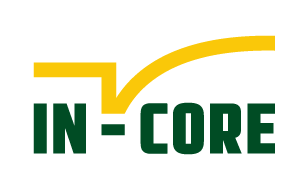


# 2022 April 28-29 SAM

# Galveston Island, Policy Levers

## Jupyter Notebook Created by:
   ### Mehrzad Rahimi, Postdoctoral fellow at Rice University (mr77@rice.edu)
   ### Omar M. Nofal, Postdoctoral fellow at Colorado State University (omar.nofal@colostate.edu)
   ### Ram K. Mazumder, Postdoctoral fellow at University of Kansas (rkmazumder@ku.edu)
   ### Nathanael Rosenheim, Research Associate Professor at Texas A&M University (nrosenheim@arch.tamu.edu)
   ### Yousef M. Darestani, Assistant Professor at Michigan Technological University (ydaresta@mtu.edu) 
   ### Jamie E. Padgett, Professor at Rice University (jamie.padgett@rice.edu)
   ### Elaina J. Sutley, Associate Professor at University of Kansas (enjsutley@ku.edu) 
   ### John W. van de Lindt, Professor at Colorado State University (john.van_de_lindt@colostate.edu) 

# IN-CORE Flowchart - Galveston
This notebook uses the Galveston testbed to demonstrate the following components of the IN-CORE flowchart.

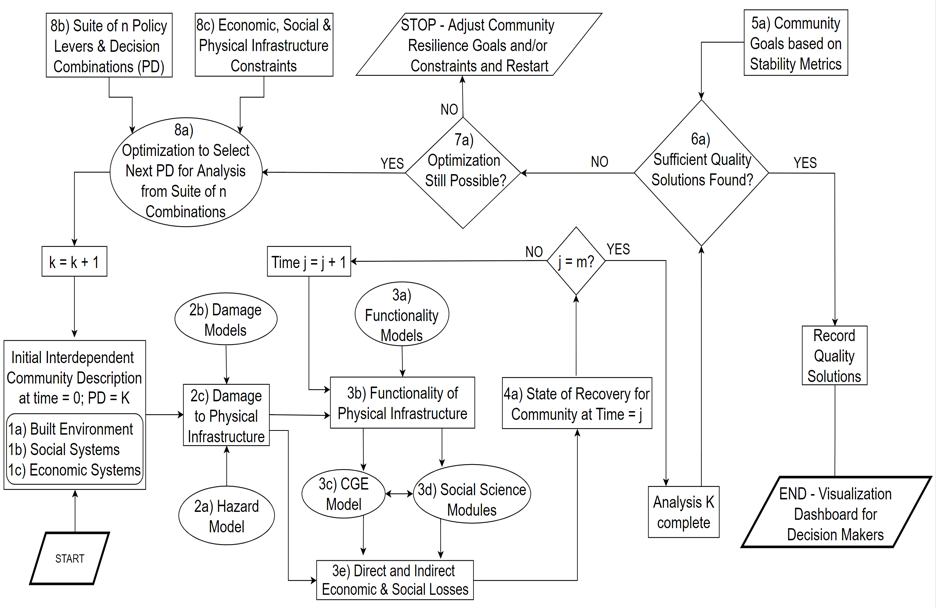

# Background
The **Galveston Testbed** is an ongoing effort of the Center to test model chaining an integration across coupled systems. The current Galveston Testbed and Jupyter notebooks released with IN-CORE focus on **Galveston Island** as a barrier island exposed to hurricane hazards. Our ongoing work extends this analysis to Galveston County, further exploring the interplay between economic activity and recovery efforts between the mainland and the island. As shown in the following figure, Galveston County is located in the southeastern part of Texas, along the Gulf Coast adjacent to Galveston Bay.

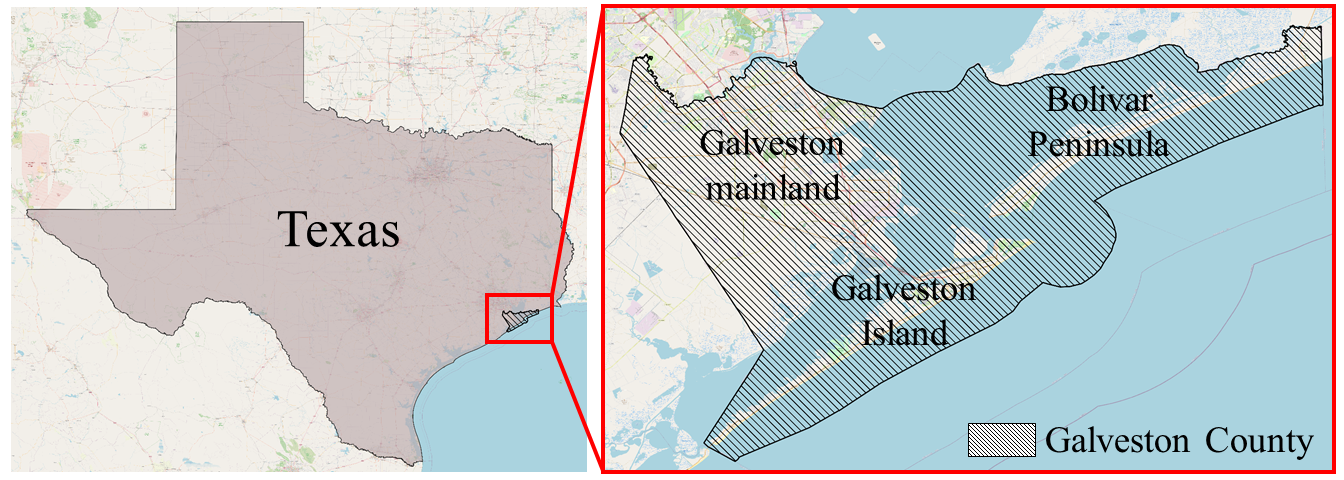

**Galveston Island** is located in southern Galveston County with a total length of 43.5 km and a width of 4.8 km. The Island is surrounded by West Bay from the west, the Gulf of Mexico from the south and east, and Galveston Bay in the North. The Galveston Island is connected to the rest of Galveston County by interstate highway I-45. Based on the 2015 county parcel data the total number of buildings within Galveston County was 172,534 buildings with 29,541 buildings located on Galveston Island. In 2010, the total population living on Galveston Island was 48,726 people with a racial/ethnic composition of 46% non-Hispanic White, 18% non-Hispanic Black, and 31% Hispanic. Galveston, Texas has a long history with hurricanes including the Great Galveston Hurricane in 1900 which is considered the deadliest natural disaster in U.S. history. More recently, the island was affected by Hurricane Ike (2008) and Hurricane Harvey (2017), each posing unique challenges in terms of coastal multi-hazards and recovery challenges, and with billions of dollars in economic impacts. 

# General info

### Some of the main objectives of the Galveston Testbed include:

1. Investigate the multi-hazard surge, wave, inundation, and wind hazards in coastal settings.
2. Consider interdependent infrastructure systems including buildings, transportation, and power.
3. Leverage historical social-science data, informing population dislocation and recovery modeling.
4. Evaluate hybrid metrics of community resilience, such as those that require coupled modeling between social and physical systems.

### More information about the testbed and the field study can be found in this publication:
1. Fereshtehnejad, E., Gidaris, I., Rosenheim, N., Tomiczek, T., Padgett, J. E., Cox, D. T., ... & Gillis Peacock, W. (2021). Probabilistic risk assessment of coupled natural-physical-social systems: cascading impact of hurricane-induced damages to civil infrastructure in Galveston, Texas. Natural Hazards Review, 22(3), 04021013.

### The current notebook is a WORK-IN-PROGRESS that consists of the following modules:
1. Flood Surge, Wave, and Inundation Modeling
2. Building Damage Analysis
3. Household Unit Allocation Modeling
4. Population Dislocation Analysis based on Hurricane IKE in 2007

### The models used in this testbed come from:
1. Nofal, O. M., Van De Lindt, J. W., Do, T. Q., Yan, G., Hamideh, S., Cox, D. T., & Dietrich, J. C. (2021). Methodology for Regional Multihazard Hurricane Damage and Risk Assessment. Journal of Structural Engineering, 147(11), 04021185.

2. Darestani, Y. M., Webb, B., Padgett, J. E., Pennison, G., & Fereshtehnejad, E. (2021). Fragility Analysis of Coastal Roadways and Performance Assessment of Coastal Transportation Systems Subjected to Storm Hazards. Journal of Performance of Constructed Facilities, 35(6), 04021088.

3. Darestani, Y., Padgett, J., & Shafieezadeh, A. (2022). Parametrized Wind–Surge–Wave Fragility Functions for Wood Utility Poles. Journal of Structural Engineering, 148(6), 04022057.

1. Rosenheim, N., Guidotti, R., Gardoni, P., & Peacock, W. G. (2021). Integration of detailed household and housing unit characteristic data with critical infrastructure for post-hazard resilience modeling. Sustainable and Resilient Infrastructure, 6(6), 385-401.

2. Sutley, E. J., & Hamideh, S. (2020). Postdisaster housing stages: a markov chain approach to model sequences and duration based on social vulnerability. Risk Analysis, 40(12), 2675-2695.

### Prerequisites:
The following packages are necessary to run this notebook. To ensure dependencies are correct, install all modules through **conda**.


| Module | Version | Notes |
| --- | --- | --- |
| pyIncore | =>1.3.0 | see: https://incore.ncsa.illinois.edu/doc/incore/install_pyincore.html |
| pyIncore_viz | =>1.5.0 | see: https://incore.ncsa.illinois.edu/doc/pyincore_viz/index.html |

# Start

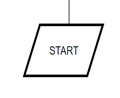

The following codes are preparing the analysis by checking versions and connecting to IN-CORE web service. Also, all of the necessary pyIncore analyses are being imported. In this analysis, the following pyIncore analyses are utilized:
* **Building damage**: Computes building damage based on a particular hazard (hurricane in this testbed).
* **Road damage**: Computes road damage based on a particular hazard (hurricane in this testbed). <font color='red'>*Not in IN-CORE yet* </font>  
* **Bridge damage**: Computes bridge damage based on a particular hazard (hurricane in this testbed).
* **Building functionality**: Calculates building functionality probabilities.
* **Housing unit allocation**: Sets up a detailed critical infrastructure inventory with housing unit level characteristics. 
* **Population dislocation**: Computes population dislocation based on a particular hazard (hurricane in this testbed).
* **Household-level housing sequential recovery**: Computes the series of household recovery states given a population dislocation dataset.
* **Transportation restoration**: Computes the series of transportation recovery states given household recovery states. <font color='red'>*Not in IN-CORE yet* </font>  

In [64]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import geopandas as gpd 
import numpy as np
import sys 
import os 
import matplotlib.pyplot as plt
import contextily as ctx
import copy
import math
from scipy.stats import norm
from pathlib import Path

from pyincore import IncoreClient, Dataset, DataService, HazardService, FragilityService, MappingSet, FragilityCurveSet
from pyincore_viz.geoutil import GeoUtil as geoviz
from pyincore_viz.plotutil import PlotUtil as plotviz

# importing pyIncone analyses:
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.bridgedamage import BridgeDamage
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
from pyincore.analyses.housingunitallocation import HousingUnitAllocation
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.housingrecoverysequential import HousingRecoverySequential

In [65]:
# Functions for visualizing the population data results as tables
from pyincore_viz.analysis.popresultstable import PopResultsTable as poptable

In [66]:
# Check package versions - good practice for replication
print("Python Version ", sys.version)
print("pandas version: ", pd.__version__)
print("numpy version: ", np.__version__)

Python Version  3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 05:59:45) [MSC v.1929 64 bit (AMD64)]
pandas version:  1.4.2
numpy version:  1.22.3


In [67]:
# Check working directory - good practice for relative path access
os.getcwd()

'c:\\MyProjects\\HRRCProjects\\IN-CORE\\WorkNPR\\github\\IN-CORE_notebooks'

In [68]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
#client.clear_cache() 
data_service = DataService(client) # create data_service object for loading files
hazard_service = HazardService(client)
fragility_services = FragilityService(client)

Connection successful to IN-CORE services. pyIncore version detected: 1.4.0


# 1) Initial community description

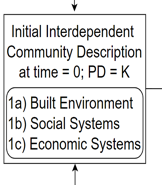

tep 1 in IN-CORE is to establish initial interdepent community description at time 0 and with policy levers and decision combinations (PD) set to K (baseline case). The community description includes three parts including **1a) Built Enviroment**, **1b) Social Systems**, and **1c) Economic Systems**.

## 1a) Built Environment
The Galveston testbed consists of five infrastructure systems as buildings, transportation network, electric power transmission and distribution network, water/wastewater network, and critical facilities. Each infrastructure system may be composed of different infrastructure components. For example, the transportation network consists of bridges and roadways. The infrastructure systems and components are shown below along with their IN-CORE GUID.

| No. | Infrastructure System | Infrastructure Component | GUID | More details |
| --- | --- | --- | --- | --- |
| 1 | Buildings | - | 60354b6c123b4036e6837ef7| Ref. |
| 2 | Transportation network | Bridges | 60620320be94522d1cb9f7f0| Ref. |
| - | Transportation network | Roadways | 5f15d04f33b2700c11fc9c4e| Ref. |
| 3 | Electric power network | Connectivity | Outside of IN-CORE| Ref. |
| - | Electric power network | Poles and Towers | Outside of IN-CORE| Ref. |
| - | Electric power network | Substation | Outside of IN-CORE| Ref. |
| - | Electric power network | Transmission | Outside of IN-CORE| Ref. |
| - | Electric power network | Underground | Outside of IN-CORE| Ref. |
| 4 | Water/wastewater network | Water mains | Outside of IN-CORE| Ref. |
| - | Water/wastewater network | Water plants | Outside of IN-CORE| Ref. |
| - | Water/wastewater network | Wastewater mains | Outside of IN-CORE| Ref. |
| 5 | Critical facilities | Hospitals | Outside of IN-CORE| Ref. |
| - | Critical facilities | Urgent care | Outside of IN-CORE| Ref. |
| - | Critical facilities | Emergency medical facilities | Outside of IN-CORE| Ref. |
| - | Critical facilities | Fire stations | Outside of IN-CORE| Ref. |
| 6 | Fiber Optic Network | - | Outside of IN-CORE| Ref. |

**Note**: The built envirtonment in the Galveston testbed are in the Galveston Island. However, as the goal is to capture flow of people during recovery stages, buildings and transportation networks in the Galveston mainland are considered as well.

### Buildings
The building inventory for Galveston consists of 18,962 individual residential households. This inventory is also mappable to housing unit info of 32,501 individual households explained later in this notebook. It should be noted that the reason that the building and household data are different in terms of numbers is that each individual building can be composed of a few households. The building inventory consists of three major parameters that are used to estimate the fragility of buildings explained shortly later in this notebook. The three parameters are: 

a) Elevation of the lowest horizontal structural member

b) Age group of the building (1, 2, 3, and 4 representing age group pre-1974, 1974–1987, 1987–1995, and 1995– 2008, respectively) 

c) Elevation of the building with respect to the ground


Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Galveston testbed building inventory as a function of age group
Number of buildings: 18962


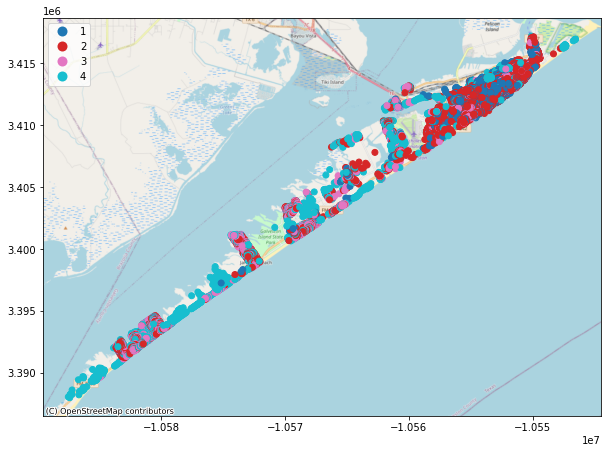

In [69]:
bldg_dataset_id = "60354b6c123b4036e6837ef7"               # defining building dataset (GIS point layer)       
bldg_dataset = Dataset.from_data_service(bldg_dataset_id, data_service)
geoviz.plot_map(bldg_dataset, column='age_group',category='True')
print('Galveston testbed building inventory as a function of age group')

bldg_df = bldg_dataset.get_dataframe_from_shapefile()
bldg_df.set_index('guid', inplace=True)
print('Number of buildings: {}' .format(len(bldg_df)))

### Transportation network
This transportation network comprises 10 bridges inside Galveston Island, 11 bridges that connect the mainland to the island, and 163 roadway segments. The bridges are mostly multiple-span simply supported girder super-structures or concrete slab. The information for bridges such asstructural system, clearance, elevation, deck and girder thicknesses, and unit mass of spans were obtained from Texas Department ofTransportation (TxDOT) inspection reports, bridge plans, and TxDOT typical bridge specifications. 

#### *Roadways*

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Galveston testbed roadway inventory


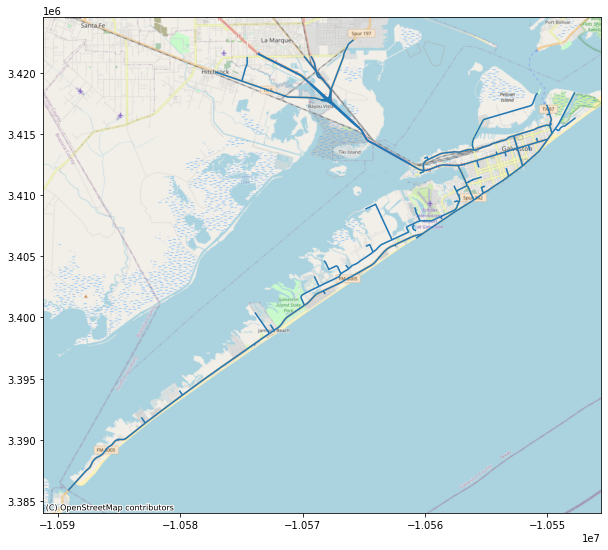

In [70]:
trns_road_dataset_id = "5f15d04f33b2700c11fc9c4e"        # defining transportation road dataset (GIS point layer)
trns_road_dataset = Dataset.from_data_service(trns_road_dataset_id, data_service)
geoviz.plot_map(trns_road_dataset, column=None, category=False)
print('Galveston testbed roadway inventory')

#### *Bridges*

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Galveston testbed bridge inventory


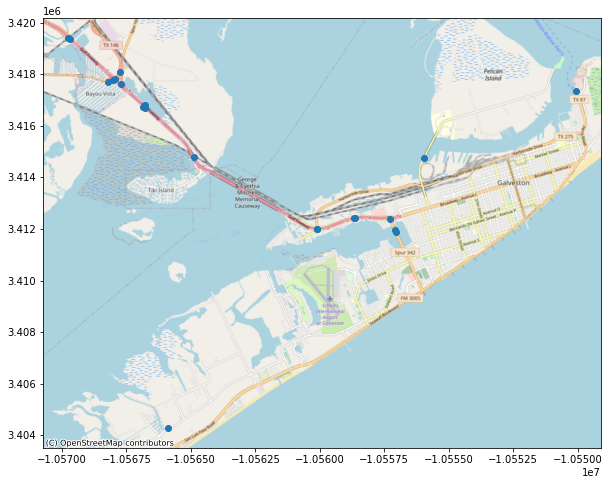

In [71]:
trns_brdg_dataset_id = "60620320be94522d1cb9f7f0"        # defining transportation bridge dataset (GIS point layer)
trns_brdg_dataset = Dataset.from_data_service(trns_brdg_dataset_id, data_service)
geoviz.plot_map(trns_brdg_dataset, column=None, category=False, basemap=True)
print('Galveston testbed bridge inventory')

### Electric power network
The power inventory for Galveston testbed was originally collected by XX using XX. 

#### *Poles & Towers*

In [72]:
'''
gdf_poles_towers = gpd.read_file('Galveston Power Inventory ShapeFile/poles & towers.shp')
       
gdf_poles_towers = gdf_poles_towers.to_crs(epsg=3857)  
fig, ax = plt.subplots(figsize=(10, 10))

gdf_poles_towers.plot(column=gdf_poles_towers.Name,categorical=True,legend=False,ax=ax,alpha=0.5,color='red',markersize= 1)
ctx.add_basemap(ax)
ax.set_axis_off()
plt.show()
'''
print('Galveston power inventory - Poles and Towers')

Galveston power inventory - Poles and Towers


#### *Substations*

In [73]:
'''
gdf_substations = gpd.read_file('Galveston Power Inventory ShapeFile/Substations.shp')
       
gdf_substations = gdf_substations.to_crs(epsg=3857)  
fig, ax = plt.subplots(figsize=(10, 10))

gdf_substations.plot(column=gdf_substations.Name,categorical=True,legend=False,ax=ax,alpha=0.5,color='red',markersize= 60)
ctx.add_basemap(ax)
ax.set_axis_off()
plt.show()

print('Galveston power inventory - Substations')
'''

"\ngdf_substations = gpd.read_file('Galveston Power Inventory ShapeFile/Substations.shp')\n       \ngdf_substations = gdf_substations.to_crs(epsg=3857)  \nfig, ax = plt.subplots(figsize=(10, 10))\n\ngdf_substations.plot(column=gdf_substations.Name,categorical=True,legend=False,ax=ax,alpha=0.5,color='red',markersize= 60)\nctx.add_basemap(ax)\nax.set_axis_off()\nplt.show()\n\nprint('Galveston power inventory - Substations')\n"

#### *Transmission*

In [74]:
'''
gdf_transmission = gpd.read_file('Galveston Power Inventory ShapeFile/Transmission.shp')
       
gdf_transmission = gdf_transmission.to_crs(epsg=3857)  
fig, ax = plt.subplots(figsize=(10, 10))

gdf_transmission.plot(column=gdf_transmission.Name,categorical=True,legend=False,ax=ax,alpha=0.5,color='green',linewidth=4)
ctx.add_basemap(ax)
ax.set_axis_off()
plt.show()

print('Galveston power inventory - Transmission')
'''

"\ngdf_transmission = gpd.read_file('Galveston Power Inventory ShapeFile/Transmission.shp')\n       \ngdf_transmission = gdf_transmission.to_crs(epsg=3857)  \nfig, ax = plt.subplots(figsize=(10, 10))\n\ngdf_transmission.plot(column=gdf_transmission.Name,categorical=True,legend=False,ax=ax,alpha=0.5,color='green',linewidth=4)\nctx.add_basemap(ax)\nax.set_axis_off()\nplt.show()\n\nprint('Galveston power inventory - Transmission')\n"

#### *Connectivity*

In [75]:
# Need to update the shapefile

#### *Underground*

In [76]:
'''
gdf_underground = gpd.read_file('Galveston Power Inventory ShapeFile/underground.shp')
       
gdf_underground = gdf_underground.to_crs(epsg=3857)  
fig, ax = plt.subplots(figsize=(10, 10))

gdf_underground.plot(column=gdf_underground.Name,categorical=True,legend=False,ax=ax,alpha=0.5,color='black',linewidth=4)
ctx.add_basemap(ax)
ax.set_axis_off()
plt.show()

print('Galveston power inventory - Underground')
'''

"\ngdf_underground = gpd.read_file('Galveston Power Inventory ShapeFile/underground.shp')\n       \ngdf_underground = gdf_underground.to_crs(epsg=3857)  \nfig, ax = plt.subplots(figsize=(10, 10))\n\ngdf_underground.plot(column=gdf_underground.Name,categorical=True,legend=False,ax=ax,alpha=0.5,color='black',linewidth=4)\nctx.add_basemap(ax)\nax.set_axis_off()\nplt.show()\n\nprint('Galveston power inventory - Underground')\n"

### Water/wastewater network
The Water/wastewater inventory for Galveston testbed was originally collected from https://gis.galvestontx.gov/GISdata/index.html

#### *Water mains*

In [77]:
'''
gdf_watermains = gpd.read_file('Galveston Water Inventory ShapeFile/W_Mains.shp')
       
gdf_watermains = gdf_watermains.to_crs(epsg=3857)  
fig, ax = plt.subplots(figsize=(10, 10))

gdf_watermains.plot(column=gdf_watermains.DIAMETER,categorical=True,legend=False,ax=ax,alpha=0.5,color='blue',linewidth=2)
ctx.add_basemap(ax)
ax.set_axis_off()
plt.show()

print('Galveston water inventory - water mains')
'''

"\ngdf_watermains = gpd.read_file('Galveston Water Inventory ShapeFile/W_Mains.shp')\n       \ngdf_watermains = gdf_watermains.to_crs(epsg=3857)  \nfig, ax = plt.subplots(figsize=(10, 10))\n\ngdf_watermains.plot(column=gdf_watermains.DIAMETER,categorical=True,legend=False,ax=ax,alpha=0.5,color='blue',linewidth=2)\nctx.add_basemap(ax)\nax.set_axis_off()\nplt.show()\n\nprint('Galveston water inventory - water mains')\n"

#### *Water plants* (pump stations, ground storage tanks and elevated storage tanks)

In [78]:
# IN-PROGRESS outside of IN-CORE

### Critical facilities
The critical facilities inventory for Galveston testbed was originally collected by XX using XX. 

#### *Fire Stations*

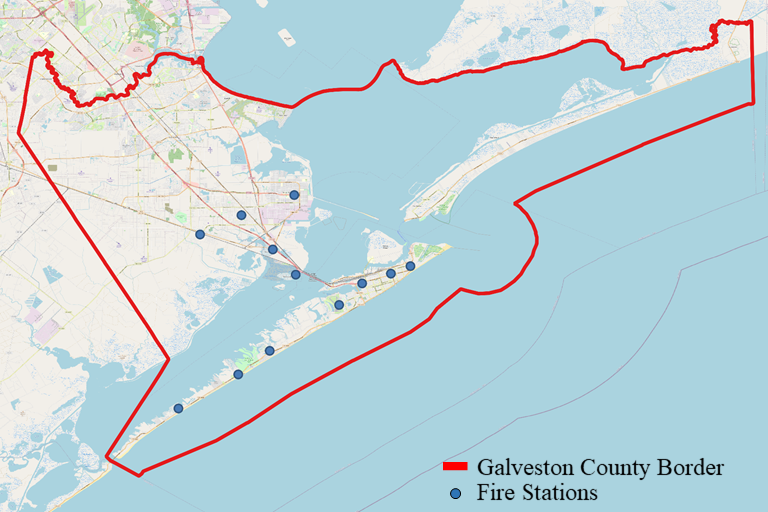

#### *Medical Centers* (Hospitals, Urgent care, Emergency medical facilities)

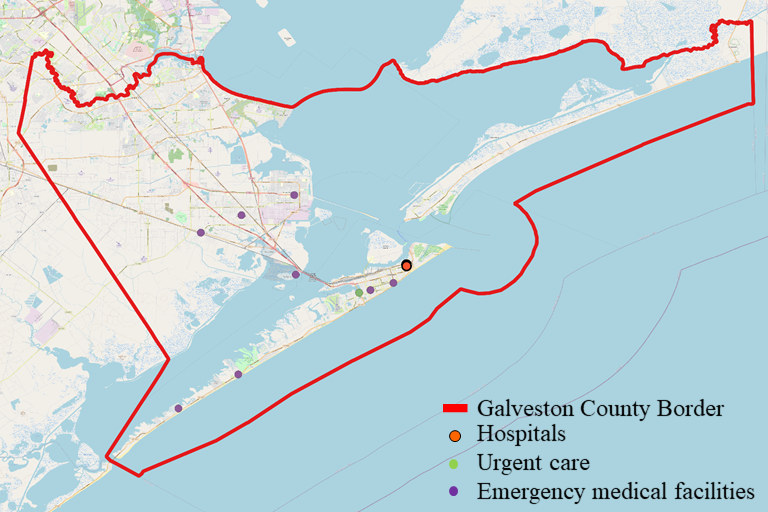

### Fiber Optic Network
The Water/wastewater inventory for Galveston testbed was originally collected by XX using XX. 

In [79]:
'''
gdf_opticcables = gpd.read_file('Galveston Fiber Optic ShapeFile/Fiber_Optic_Cables_Draft.shp')
       
gdf_opticcables = gdf_opticcables.to_crs(epsg=3857)  
fig, ax = plt.subplots(figsize=(10, 10))

gdf_opticcables.plot(column=gdf_opticcables.TYPE,categorical=True,legend=False,ax=ax,alpha=0.5,color='orange',linewidth=8)
ctx.add_basemap(ax)
ax.set_axis_off()
plt.show()

print('Galveston fiber optic inventory - cables')
'''

"\ngdf_opticcables = gpd.read_file('Galveston Fiber Optic ShapeFile/Fiber_Optic_Cables_Draft.shp')\n       \ngdf_opticcables = gdf_opticcables.to_crs(epsg=3857)  \nfig, ax = plt.subplots(figsize=(10, 10))\n\ngdf_opticcables.plot(column=gdf_opticcables.TYPE,categorical=True,legend=False,ax=ax,alpha=0.5,color='orange',linewidth=8)\nctx.add_basemap(ax)\nax.set_axis_off()\nplt.show()\n\nprint('Galveston fiber optic inventory - cables')\n"

## 1b) Social Systems
The Galveston Island has a permanent resident population of approximately 53,695 people (US Census, 2020). In 2010, the total population living on Galveston Island was 48,726. This section performs a housing unit allocation. The housing unit inventory includes characteristics for individual households and housing units that can be linked to residential buildings. For more information see Rosenheim et al. (2019).

In [80]:
# Housing Unit inventory
housing_unit_inv_id = "61d783eb3ed7dd5c873b42d2"
# load housing unit inventory as pandas dataframe
housing_unit_inv = Dataset.from_data_service(housing_unit_inv_id, data_service)
filename = housing_unit_inv.get_file_path('csv')
print("The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: "+filename)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\61d783eb3ed7dd5c873b42d2\hui_v0-1-0_Galveston_TX_2010_rs9876\hui_v0-1-0_Galveston_TX_2010_rs9876.csv


In [81]:
housing_unit_inv_df = pd.read_csv(filename, header="infer")
housing_unit_inv_df.head()

,huid,blockid,tractid,bgid,FIPScounty,numprec,ownershp,race,hispan,vacancy,gqtype,incomegroup,randincome,hhinc
0,B481677201001000H001,481677201001000,48167720100,481677201001,48167,1,1.0,1.0,0.0,0.0,0.0,16.0,249702.0,5.0
1,B481677201001000H002,481677201001000,48167720100,481677201001,48167,1,1.0,1.0,0.0,0.0,0.0,16.0,206115.0,5.0
2,B481677201001000H003,481677201001000,48167720100,481677201001,48167,1,1.0,1.0,0.0,0.0,0.0,15.0,185826.0,5.0
3,B481677201001000H004,481677201001000,48167720100,481677201001,48167,1,1.0,1.0,0.0,0.0,0.0,7.0,36896.0,3.0
4,B481677201001000H005,481677201001000,48167720100,481677201001,48167,1,1.0,1.0,0.0,0.0,0.0,11.0,63897.0,3.0


In [82]:
housing_unit_inv_df['huid'].describe()

count                   132553
unique                  132553
top       B481677201001000H001
freq                         1
Name: huid, dtype: object

In [83]:
poptable.pop_results_table(housing_unit_inv_df, 
                  who = "Total Population by Householder", 
                  what = "by Race, Ethnicity",
                  where = "Galveston County TX",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Householder (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","137,132 (67.3%)","37,790 (46.2%)","174,922 (61.3%)"
"2 Black alone, Not Hispanic","19,133 (9.4%)","18,286 (22.4%)","37,419 (13.1%)"
"3 American Indian and Alaska Native alone, Not Hispanic",745 (0.4%),360 (0.4%),"1,105 (0.4%)"
"4 Asian alone, Not Hispanic","6,304 (3.1%)","1,717 (2.1%)","8,021 (2.8%)"
"5 Other Race, Not Hispanic","2,000 (1.0%)",931 (1.1%),"2,931 (1.0%)"
"6 Any Race, Hispanic","38,504 (18.9%)","22,633 (27.7%)","61,137 (21.4%)"
Total,"203,818 (100.0%)","81,717 (100.0%)","285,535 (100.0%)"


## 1a + 1b) Interdependent Community Description

Explore building inventory and social systems. Specifically look at how the building inventory connects with the housing unit inventory using the housing unit allocation.
The housing unit allocation method will provide detail demographic characteristics for the community allocated to each structure.

To run the HUA Algorithm, three input datasets are required:

1. Housing Unit Inventory - Based on 2010 US Census Block Level Data

2. Address Point Inventory - A list of all possible residential/business address points in a community. Address points are the link between buildings and housing units.

3. Building Inventory - A list of all buildings within a community.


### Set Up and Run Housing Unit Allocation
The building and housing unit inventories have already by loaded. The address point inventory is needed to link the population with the structures.

In [84]:
# Create housing allocation 
hua = HousingUnitAllocation(client)

address_point_inv_id = "5fc6aadcc38a0722f563392e"

# Load input dataset
hua.load_remote_input_dataset("housing_unit_inventory", housing_unit_inv_id)
hua.load_remote_input_dataset("address_point_inventory", address_point_inv_id)
hua.load_remote_input_dataset("buildings", bldg_dataset_id)

# Specify the result name
result_name = "Lumberton_HUA"

seed = 1238
iterations = 1

# Set analysis parameters
hua.set_parameter("result_name", result_name)
hua.set_parameter("seed", seed)
hua.set_parameter("iterations", iterations)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [85]:
# Run Housing unit allocation analysis
hua.run_analysis()

True

### Explore results from Housing Unit Allocation

In [86]:
# Retrieve result dataset
hua_result = hua.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
hua_df = hua_result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
hua_df[['guid','numprec','incomegroup','geometry']].head()

,guid,numprec,incomegroup,geometry
0,eca98323-d57f-4691-a340-b4e0e19c2346,2,10.0,POINT (-94.79252 29.3092)
1,eca98323-d57f-4691-a340-b4e0e19c2346,2,3.0,POINT (-94.79252 29.3092)
2,eca98323-d57f-4691-a340-b4e0e19c2346,1,10.0,POINT (-94.79252 29.3092)
3,eca98323-d57f-4691-a340-b4e0e19c2346,2,14.0,POINT (-94.79252 29.3092)
4,eca98323-d57f-4691-a340-b4e0e19c2346,2,16.0,POINT (-94.79252 29.3092)


In [87]:
poptable.pop_results_table(hua_df.loc[hua_df['guid'].notnull()].copy(), 
                  who = "Total Population by Householder", 
                  what = "by Race, Ethnicity",
                  where = "Galveston Island, TX - Buildings in Inventory",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Householder (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","12,684 (55.2%)","8,525 (38.0%)","21,209 (46.7%)"
"2 Black alone, Not Hispanic","2,723 (11.9%)","5,339 (23.8%)","8,062 (17.7%)"
"3 American Indian and Alaska Native alone, Not Hispanic",77 (0.3%),114 (0.5%),191 (0.4%)
"4 Asian alone, Not Hispanic",614 (2.7%),775 (3.5%),"1,389 (3.1%)"
"5 Other Race, Not Hispanic",233 (1.0%),290 (1.3%),523 (1.2%)
"6 Any Race, Hispanic","6,646 (28.9%)","7,402 (33.0%)","14,048 (30.9%)"
Total,"22,977 (100.0%)","22,445 (100.0%)","45,422 (100.0%)"


In [88]:
poptable.pop_results_table(hua_df, 
                  who = "Median Household Income", 
                  what = "by Race, Ethnicity",
                  where = "Galveston Island, TX - Buildings in Inventory",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied,2 Renter Occupied,Median Household Income
Race Ethnicity,,,
"1 White alone, Not Hispanic","$76,297","$61,179","$72,460"
"2 Black alone, Not Hispanic","$40,726","$32,367","$36,562"
"3 American Indian and Alaska Native alone, Not Hispanic","$58,586","$46,768","$52,892"
"4 Asian alone, Not Hispanic","$70,612","$44,728","$63,255"
"5 Other Race, Not Hispanic","$61,130","$50,626","$56,313"
"6 Any Race, Hispanic","$53,367","$42,668","$48,958"
Total,"$68,180","$49,199","$61,612"


#### Validate the Housing Unit Allocation has worked
Notice that the population count totals for the community should match (pretty closely) data collected for the 2010 Decennial Census.
This can be confirmed by going to data.census.gov

Total Population by Race and Ethnicity:
https://data.census.gov/cedsci/table?q=DECENNIALPL2010.P5&g=1600000US4828068,4837252&tid=DECENNIALSF12010.P5

Median Income by Race and Ethnicity:
- All Households: https://data.census.gov/cedsci/table?g=1600000US4828068,4837252&tid=ACSDT5Y2012.B19013
- Black Households: https://data.census.gov/cedsci/table?g=1600000US4828068,4837252&tid=ACSDT5Y2012.B19013B
- White, not Hispanic Households: https://data.census.gov/cedsci/table?g=1600000US4828068,4837252&tid=ACSDT5Y2012.B19013H
- Hispanic Households: https://data.census.gov/cedsci/table?g=1600000US4828068,4837252&tid=ACSDT5Y2012.B19013I
    
Differences in the housing unit allocation and the Census count may be due to differences between political boundaries and the building inventory. See Rosenheim et al 2019 for more details.

The housing unit allocation, plus the building results will become the input for the social science models such as the population dislocation model.

## 1b) Economic Systems
For the CGE model, each parcel is mapped to an economic sector. The sector of each parcel is plotted spatially. For more information see XX.

In [89]:
# load id
# Showing count of number of parcels in each sector
# Showing the real market value of parcels by sector

# 2) Hazards and Damages

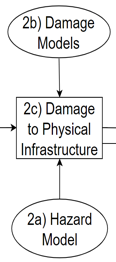

## 2a) Hazard Model (Hurricane)
There are currently five hurricane hazard data for Galveston testbed. Four of them were created using the dynamically coupled versions of the Advanced Circulation (ADCIRC) and Simulating Waves Nearshore (SWAN) models. One of them is a surrogate model developed using USACE datasets.

| No. | Simulation type | Name | GUID | More details |
| --- | --- | --- | --- | --- |
| 1 | Coupled ADCIRC+SWAN | Hurricane Ike Hindcast | <font color='red'>5fa5a228b6429615aeea4410 </font> | Darestani et al. (2021) |
| 2 | Coupled ADCIRC+SWAN | 2% AEP Hurricane Simulation | <font color='red'>5fa5a83c7e5cdf51ebf1adae </font> | Darestani et al. (2021) |
| 3 | Coupled ADCIRC+SWAN | 1% AEP Hurricane Simulation | <font color='red'>5fa5a9497e5cdf51ebf1add2 </font> | Darestani et al. (2021) |
| 4 | Coupled ADCIRC+SWAN | 0.2% AEP Hurricane Simulation | <font color='red'>5fa5aa19b6429615aeea4476 </font> | Darestani et al. (2021) |
| 5 | Kriging-based surrogate model | Galveston Deterministic Hurricane - Kriging | <font color='red'>5f15cd627db08c2ccc4e3bab </font> | Fereshtehnejad et al. (2021) |


### Coupled ADCIRC+SWAN
Galveston Island was struck by Hurricane Ike in September, 2008, with maximum windspeeds of 49 m/s (95 kts) and storm surge elevations reaching at least +3.5 m (NAVD88) on Galveston Island. A full hindcast of Hurricane Ike’s water levels, and wave conditions along with 2% (50-yr return period), 1% (100-yr return period), and 0.2% (500-yr return period) Annual Exceedance Probabilities (AEP) hurricane simulations were created using ADCIRC+SWAN models. These hurricane hazard events contain **eight hazardDatasets**, which is five more than the current pyincore hurricane schema. Please be sure to adjust your codes accordingly if you need to incorporate the five new intensity measures (IMs). The existing schema includes the peak significant wave height, peak surge level, and inundation duration. These new events include those as well as maximum inundation depth, peak wave period, wave direction, maximum current speed, and maximum wind speed. 

### Kriging-based surrogate model
**Three hazardDatasets** of kriging-based surrogate models are developed for peak significant wave height, peak surge level, and inundation duration. Training datasets for developing the Kriging surorgate models were collected through USACE. For the peak significant wave height, peak surge level, and inundation duration the training datasets included 61, 251, and 254 synthetic storms, respectively. 

In [90]:
# read hazard
# plot hazard

## 2b) Damage Models
xxx

## 2c) Damage to Physical Infrastructure
XXX

### Building damage

### 2.1 Building Fragility

The fragility model used to estimate failure probability during storm surge events is extracted from:

>Tomiczek, T. Kennedy, A, and Rogers, S., 2013. Collapse limit state fragilities of wood-framed residences from storm surge and waves during Hurricane Ike. Journal of Waterway, Port, Coastal, and Ocean Engineering, 140(1), pp.43-55.

This empirical fragility model was developed based on Hurricane Ike surveys of almost 2000 individual wood-frame buildings coupled with high resolution hindcast of the hurricane. For this study two states of damage, “Collapse” and “Survival” were considered.
________________________________________
The input parameters to the fragility model are:

1) Surge: surge level (m) coming from hazard data

2) Hs: Significant wave height (m) coming from hazard data

3) LHSM: Elevation of the lowest horizontal structural member (ft) coming from building inventory

4) age_group: Age group of the building (1, 2,3, and 4 representing age group pre-1974, 1974–1987, 1987–1995, and 1995– 2008, respectively) coming from building Inventory

5) G_elev: Elevation of the building with respect to the ground (m) coming from building inventory
________________________________________
Output:
Pf: probability of failure
________________________________________
In order to calculate the probability of failure, first we need to estimate the relative surge height compared to the ground level from:
𝑑𝑠=𝑆𝑢𝑟𝑔𝑒−𝐺𝑒𝑙𝑒𝑣ds

Subsequently, we need to calculate the following parameter

𝐹𝐵ℎ𝑠=−(𝑑𝑠+0.7∗𝐻𝑠−𝐿𝐻𝑆𝑀∗0.3048)
Note: 0.3048 is to convert ft to m as the inventory data are in ft.

Then:

For FB_hs>= -2.79*Hs the probability of failure is calculated as:
𝑃𝑓=Φ(−3.56+1.52∗𝐻𝑠−1.73∗𝐻𝑠∗𝐹𝐵ℎ𝑠−0.31∗𝐹𝐵2ℎ𝑠−0.141∗𝑎𝑔𝑒2𝑔𝑟𝑜𝑢𝑝)

and for FB_hs< -2.79*Hs
𝑃𝑓=Φ(−3.56+1.52∗𝐻𝑠+2.42∗𝐹𝐵2ℎ𝑠−0.141∗𝑎𝑔𝑒2𝑔𝑟𝑜𝑢𝑝)
Where Φ denotes the Cumulative Density Function (CDF) of standard normal distribution.
________________________________________
Example:
If Surge=3 m, Hs =2 m, LHSM=9 ft, age_group=4; G_elev =1 m
Then Pf= 0.2620


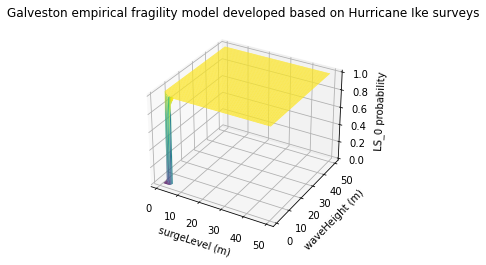

In [91]:
# use utility method of pyicore-viz package to visualize the fragility
fragility_set = FragilityCurveSet(FragilityService(client).get_dfr3_set("5f6ccf67de7b566bb71b202d"))
plt = plotviz.get_fragility_plot_3d(fragility_set, 
                                            title="Galveston empirical fragility model developed "
                                            "based on Hurricane Ike surveys",
                                            limit_state="LS_0")
plt.show()

In [92]:
hazard_type = "hurricane"
# Galveston deterministic Hurricane, 3 datasets - Kriging
hazard_id = "5fa5a228b6429615aeea4410"
# visualization
wave_height_id = "5f15cd62c98cf43417c10a3f"
surge_level_id = "5f15cd5ec98cf43417c10a3b"

# Hurricane building mapping (with equation)
mapping_id = "602c381a1d85547cdc9f0675"
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

In [93]:
# visualize wave height
dataset = Dataset.from_data_service(wave_height_id, DataService(client))
map = geoviz.map_raster_overlay_from_file(dataset.get_file_path('tif'))
map

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [94]:
# add opacity control - NOTE: It takes time before the opacity takes effect.
map.layers[1].interact(opacity=(0.0,1.0,0.01))

Box(children=(FloatSlider(value=1.0, description='opacity', max=1.0, step=0.01),))

In [95]:
# visualize surge level
dataset = Dataset.from_data_service(surge_level_id, DataService(client))
map = geoviz.map_raster_overlay_from_file(dataset.get_file_path('tif'))

map

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [96]:
# add opacity control - NOTE: It takes time before the opacity takes effect.
map.layers[1].interact(opacity=(0.0,1.0,0.01))

Box(children=(FloatSlider(value=1.0, description='opacity', max=1.0, step=0.01),))

### 2.2 Building Damage

In [97]:
bldg_dmg = BuildingDamage(client)

bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
bldg_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [98]:
result_name = "Galveston_bldg_dmg_result"

bldg_dmg.set_parameter("fragility_key", "Hurricane SurgeLevel and WaveHeight Fragility ID Code")
bldg_dmg.set_parameter("result_name", result_name)
bldg_dmg.set_parameter("hazard_type", hazard_type)
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("num_cpu", 4)

True

In [99]:
bldg_dmg.run_analysis()

True

### 2.3 Explore Building Damage Results

In [100]:
# Retrieve result dataset
building_dmg_result = bldg_dmg.get_output_dataset('ds_result')

In [101]:
# Convert dataset to Pandas DataFrame
bdmg_df = building_dmg_result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
bdmg_df.head()

,guid,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,haz_expose
0,b39dd67f-802e-402b-b7d5-51c4bbed3464,0.000000e+00,0.0,0.0,1.0,0,0,0.000000e+00,yes
1,e7467617-6844-437e-a938-7300418facb8,8.600000e-08,0.0,0.0,1.0,0,0,8.600000e-08,yes
2,d7ce12df-660d-42fc-9786-f0f543c00002,0.000000e+00,0.0,0.0,1.0,0,0,0.000000e+00,partial
3,74aac543-8aae-4779-addf-754e307a772b,0.000000e+00,0.0,0.0,1.0,0,0,0.000000e+00,partial
4,ed3147d3-b7b8-49da-96a9-ddedfccae60c,0.000000e+00,0.0,0.0,1.0,0,0,0.000000e+00,partial


In [102]:
bdmg_df.DS_0.describe()

count    18962.000000
mean         0.885130
std          0.307711
min          0.000000
25%          0.999588
50%          1.000000
75%          1.000000
max          1.000000
Name: DS_0, dtype: float64

In [103]:
bdmg_df.DS_3.describe()

count    18962.000000
mean         0.114870
std          0.307711
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000412
max          1.000000
Name: DS_3, dtype: float64

### Transportation network damage

In [104]:
# in incore
# Explore Monte-Carlo Damage Results

### Electric power network damage

In [105]:
# call outside of incore
# Explore Monte-Carlo Damage Results
# Modeling the damage and recovery of interdependent critical infrastructure systems from natural hazards: Fragility of lattice powers

### Water/wastewater network damage

In [106]:
# Does not exist yet

# 3) Functionality

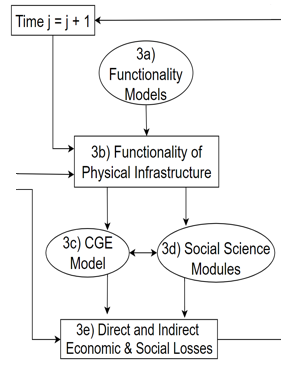

## 3a) Functionality Models

## 3b) Functionality of Physical Infrastructure

## 3c) CGE Model

## 3d) Social Science Modules

Population Dislocation
Population dislocation refers to households that will be forced to leave their pre-event residence due to hazard related damages. Population dislocation is a function of structure value loss due to damage, neighborhood characteristics and structure type.

#### 3d.1 Use new pyincore-data utility to obtain Block Group Data for County

In [107]:
from pyincore_data.censusutil import CensusUtil
state_counties = ['48167']
blockgroup_df, bgmap = CensusUtil.get_blockgroupdata_for_dislocation(state_counties, 
                                                out_csv=True, 
                                                out_shapefile=False, 
                                                out_html=False,
                                                program_name = "BlockGroupData",
                                                geo_name = "Galveston")

INFO - censusutil.py:get_blockgroupdata_for_dislocation() - Census API data from: https://api.census.gov/data/2010/dec/sf1?get=GEO_ID,NAME,P005001,P005003,P005004,P005010&for=block%20group&in=state:48&in=county:167


1940
P005001 converted from object to integer
P005003 converted from object to integer
P005004 converted from object to integer
P005010 converted from object to integer
CSV data file saved to: BlockGroupData/BlockGroupData_Galveston.csv


In [108]:
blockgroup_df.head()


,bgid,bgidstr,Survey,pblackbg,phispbg
0,481677201001,BG481677201001,2010 dec/sf1,1.726539,8.911167
1,481677201002,BG481677201002,2010 dec/sf1,0.808407,18.108327
2,481677201003,BG481677201003,2010 dec/sf1,0.956023,17.304015
3,481677202001,BG481677202001,2010 dec/sf1,1.625282,6.952596
4,481677202002,BG481677202002,2010 dec/sf1,1.735488,9.634949


In [109]:
bg_data = Dataset.from_file(
    'BlockGroupData/BlockGroupData_Galveston.csv',
    'incore:blockGroupData')

#### 3d.2 Population Dislocation

In [110]:
# Value loss parameters DS 0-3
value_loss = "60354810e379f22e16560dbd"

In [111]:
pop_dis = PopulationDislocation(client)


In [112]:
pop_dis.set_input_dataset("block_group_data", bg_data)
pop_dis.load_remote_input_dataset("value_loss_param", value_loss)

pop_dis.set_input_dataset("building_dmg", building_dmg_result)
pop_dis.set_input_dataset("housing_unit_allocation", hua_result)

result_name = "galveston-pop-disl-results"
seed = 1111

pop_dis.set_parameter("result_name", result_name)
pop_dis.set_parameter("seed", seed)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [113]:
pop_dis.run_analysis()

True

#### 3.d.3 Explore Population Dislocation Results

In [114]:
# Retrieve result dataset
result = pop_dis.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
pd_df = result.get_dataframe_from_csv(low_memory=False)

In [115]:
poptable.pop_results_table(pd_df, 
                  who = "Total Population by Households", 
                  what = "by Tenure Status and Dislocation",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = "Tenure Status",
                  col_index = 'Population Dislocation',
                  row_percent = '1 Dislocates')

Population Dislocation,0 Does not dislocate (%),1 Dislocates (%),Total Population by Households (%),Percent Row 1 Dislocates
Tenure Status,,,,
1 Owner Occupied,"8,237 (51.4%)","1,688 (40.6%)","9,925 (49.2%)",17.0%
2 Renter Occupied,"7,789 (48.6%)","2,465 (59.4%)","10,254 (50.8%)",24.0%
Total,"16,026 (100.0%)","4,153 (100.0%)","20,179 (100.0%)",20.6%


In [116]:
poptable.pop_results_table(pd_df, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity and Dislocation",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Population Dislocation',
                  row_percent = '1 Dislocates')

Population Dislocation,0 Does not dislocate (%),1 Dislocates (%),Total Population by Households (%),Percent Row 1 Dislocates
Race Ethnicity,,,,
"1 White alone, Not Hispanic","8,527 (53.2%)","2,377 (57.2%)","10,904 (54.0%)",21.8%
"2 Black alone, Not Hispanic","2,917 (18.2%)",581 (14.0%),"3,498 (17.3%)",16.6%
"3 American Indian and Alaska Native alone, Not Hispanic",67 (0.4%),16 (0.4%),83 (0.4%),19.3%
"4 Asian alone, Not Hispanic",447 (2.8%),189 (4.5%),636 (3.1%),29.7%
"5 Other Race, Not Hispanic",181 (1.1%),51 (1.2%),232 (1.1%),22.0%
"6 Any Race, Hispanic","3,887 (24.2%)",939 (22.6%),"4,826 (23.9%)",19.5%
7 Group Quarters no Race Ethnicity Data,10 (0.1%),3 (0.1%),13 (0.1%),23.1%
Total,"16,036 (100.0%)","4,156 (100.0%)","20,192 (100.0%)",20.6%


In [117]:
# Add household income group categories for table
# Code will be added to next release of pop_results_table on pyincore-viz
def add_cat_details_df(df, conditions):
    """add Damage Failure Categories information to Pop dataframe.
    Args:
        df (obj): Pandas DataFrame object.
    Returns:
        object: Pandas DataFrame object.
    """

    cat_var = conditions['cat_var']['variable_label']

    df[cat_var] = "No Data"

    for item in conditions['condition_list'].keys():
        condition =  conditions['condition_list'][item]['condition']
        value_label = conditions['condition_list'][item]['value_label']
        df.loc[eval(condition), cat_var] = value_label

    # Set variable to missing if no data- makes tables look nicer
    df.loc[(df[cat_var] == "No Data"), 
        cat_var] = np.nan

    return df

hhinc_conditions = {'cat_var': {'variable_label' : 'Household Income Group',
                                'notes' : '5 Household Income Groups based on random income.'},
                    'condition_list' : {
                        1 : {'condition': "(df['hhinc'] == 1)", 'value_label': "1 Less than $15,000"},
                        2 : {'condition': "(df['hhinc'] == 2)", 'value_label': "2 $15,000 to $24,999"},
                        3 : {'condition': "(df['hhinc'] == 3)", 'value_label': "3 $25,000 to $74,999"},
                        4 : {'condition': "(df['hhinc'] == 4)", 'value_label': "4 $75,000 to $99,999"},
                        5 : {'condition': "(df['hhinc'] == 5)", 'value_label': "5 $100,000 or more"}}
                    }

pd_df = add_cat_details_df(pd_df, conditions = hhinc_conditions)

In [118]:
poptable.pop_results_table(pd_df, 
                  who = "Total Households", 
                  what = "by Household Income Group and Dislocation",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = "Household Income Group",
                  col_index = 'Population Dislocation',
                  row_percent = '1 Dislocates')

Population Dislocation,0 Does not dislocate (%),1 Dislocates (%),Total Households (%),Percent Row 1 Dislocates
Household Income Group,,,,
"1 Less than $15,000","3,391 (21.2%)",837 (20.2%),"4,228 (21.0%)",19.8%
"2 $15,000 to $24,999","2,079 (13.0%)",481 (11.6%),"2,560 (12.7%)",18.8%
"3 $25,000 to $74,999","6,591 (41.1%)","1,776 (42.8%)","8,367 (41.5%)",21.2%
"4 $75,000 to $99,999","1,594 (9.9%)",377 (9.1%),"1,971 (9.8%)",19.1%
"5 $100,000 or more","2,371 (14.8%)",682 (16.4%),"3,053 (15.1%)",22.3%
Total,"16,026 (100.0%)","4,153 (100.0%)","20,179 (100.0%)",20.6%


#### 3.d.4 Explore Population Dislocation and Building Damage Results

In [119]:
ds3_conditions = {'cat_var' : {'variable_label' : 'Probability Complete Failure',
                         'notes' : 'Probability of complete failure based on damage state 3'},
              'condition_list' : {
                1 : {'condition': "(df['DS_3'] == 0)", 'value_label': "0 0%"},
                2 : {'condition': "(df['DS_3'] > 0)", 'value_label': "1 Less than 20%"},
                3 : {'condition': "(df['DS_3'] > .2)", 'value_label': "2 20-40%"},
                4 : {'condition': "(df['DS_3'] > .4)", 'value_label': "3 40-60%"},
                5 : {'condition': "(df['DS_3'] > .6)", 'value_label': "4 60-80%"},
                6 : {'condition': "(df['DS_3'] > .8)", 'value_label': "5 80-100%"},
                7 : {'condition': "(df['DS_3'] == 1)", 'value_label': "6 100%"}}
            }
        
dsf_conditions = {'cat_var' : {'variable_label' : 'Single Family Dwelling',
                         'notes' : 'Categories for single family dwellings'},
              'condition_list' : {
                1 : {'condition': "(df['d_sf'] == 0)", 'value_label': "0 Not Single Family"},
                2 : {'condition': "(df['d_sf'] == 1)", 'value_label': "1 Single Family"}}
            }

In [120]:
pd_df = add_cat_details_df(pd_df, conditions = ds3_conditions)
pd_df = add_cat_details_df(pd_df, conditions = dsf_conditions)

In [121]:
poptable.pop_results_table(pd_df, 
                  who = "Total Households", 
                  what = "by Probability of Complete Failure and Dislocation",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = 'Probability Complete Failure',
                  col_index = 'Population Dislocation',
                  row_percent = '1 Dislocates')

Population Dislocation,0 Does not dislocate (%),1 Dislocates (%),Total Households (%),Percent Row 1 Dislocates
Probability Complete Failure,,,,
0 0%,"15,069 (58.3%)",nan (nan%),"15,069 (46.4%)",nan%
1 Less than 20%,"9,146 (35.4%)","2,633 (39.7%)","11,779 (36.2%)",22.4%
2 20-40%,123 (0.5%),67 (1.0%),190 (0.6%),35.3%
3 40-60%,88 (0.3%),64 (1.0%),152 (0.5%),42.1%
4 60-80%,109 (0.4%),102 (1.5%),211 (0.6%),48.3%
5 80-100%,648 (2.5%),"1,570 (23.7%)","2,218 (6.8%)",70.8%
6 100%,683 (2.6%),"2,199 (33.1%)","2,882 (8.9%)",76.3%
Total,"25,866 (100.0%)","6,635 (100.0%)","32,501 (100.0%)",20.4%


In [122]:
poptable.pop_results_table(pd_df.loc[(pd_df['DS_3'] > .8)], 
                  who = "Total Population by Households", 
                  what = "for High Damaged Structures by Single Family Dwelling",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = 'Single Family Dwelling',
                  col_index = 'Population Dislocation',
                  row_percent = '0 Does not dislocate')

Population Dislocation,0 Does not dislocate (%),1 Dislocates (%),Total Population by Households (%),Percent Row 0 Does not dislocate
Single Family Dwelling,,,,
0 Not Single Family,725 (54.5%),"2,580 (68.5%)","3,305 (64.8%)",21.9%
1 Single Family,606 (45.5%),"1,189 (31.5%)","1,795 (35.2%)",33.8%
Total,"1,331 (100.0%)","3,769 (100.0%)","5,100 (100.0%)",26.1%


In [123]:
poptable.pop_results_table(pd_df.loc[(pd_df['DS_3'] > .8)], 
                  who = "Total Population by Households", 
                  what = "for High Damaged Structures by Race Ethnicity",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = 'Race Ethnicity',
                  col_index = 'Population Dislocation',
                  row_percent = '0 Does not dislocate')

Population Dislocation,0 Does not dislocate (%),1 Dislocates (%),Total Population by Households (%),Percent Row 0 Does not dislocate
Race Ethnicity,,,,
"1 White alone, Not Hispanic",509 (55.2%),"1,507 (59.9%)","2,016 (58.6%)",25.2%
"2 Black alone, Not Hispanic",143 (15.5%),316 (12.6%),459 (13.3%),31.2%
"3 American Indian and Alaska Native alone, Not Hispanic",3 (0.3%),13 (0.5%),16 (0.5%),18.8%
"4 Asian alone, Not Hispanic",33 (3.6%),134 (5.3%),167 (4.9%),19.8%
"5 Other Race, Not Hispanic",7 (0.8%),29 (1.2%),36 (1.0%),19.4%
"6 Any Race, Hispanic",227 (24.6%),517 (20.5%),744 (21.6%),30.5%
7 Group Quarters no Race Ethnicity Data,nan (nan%),1 (0.0%),1 (0.0%),nan%
Total,922 (100.0%),"2,517 (100.0%)","3,439 (100.0%)",26.8%


In [124]:
poptable.pop_results_table(pd_df.loc[(pd_df['DS_3'] > .8)], 
                  who = "Total Population by Households", 
                  what = "for High Damaged Structures by Household Income",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = 'Household Income Group',
                  col_index = 'Population Dislocation',
                  row_percent = '0 Does not dislocate')

Population Dislocation,0 Does not dislocate (%),1 Dislocates (%),Total Population by Households (%),Percent Row 0 Does not dislocate
Household Income Group,,,,
"1 Less than $15,000",163 (17.7%),503 (20.0%),666 (19.4%),24.5%
"2 $15,000 to $24,999",110 (11.9%),264 (10.5%),374 (10.9%),29.4%
"3 $25,000 to $74,999",391 (42.4%),"1,082 (43.0%)","1,473 (42.8%)",26.5%
"4 $75,000 to $99,999",82 (8.9%),231 (9.2%),313 (9.1%),26.2%
"5 $100,000 or more",176 (19.1%),436 (17.3%),612 (17.8%),28.8%
Total,922 (100.0%),"2,516 (100.0%)","3,438 (100.0%)",26.8%


## 3e) Direct and Indirect Economic & Social Losses

# 4) Recovery

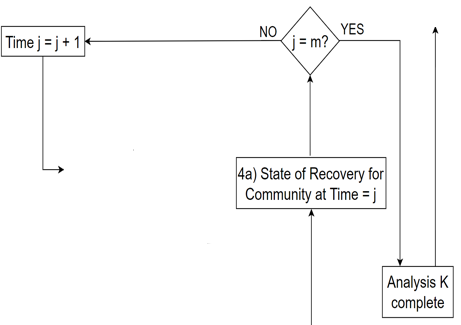

* **j** is the index for time 
* **m** is the community lifetime
* **K** is the index for policy levers and decision combinations (PD)

In [125]:
# in incore